# 利用 $PyTorch$ 中的接口直接建立循环神经网络

In [2]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib_inline import backend_inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


import funcs

backend_inline.set_matplotlib_formats('svg')

In [155]:
device="cuda:1"
batch_size, num_steps = 32, 50
num_hiddens = 1024
train_iter, vocab = funcs.load_data_time_machine(batch_size, num_steps, token_type="char")
num_embedding = len(vocab)

In [4]:
rnn_layer = nn.RNN(28, num_hiddens).to(device)

输入的形状：  ` (NumSteps, BatchSize, NumEmbedding) ` 

隐藏层的形状：` (NumLayers, BatchSize, NumHiddens) ` 

注意, `nn.RNN()` 仅构建了输入层与隐藏层，输出层需要额外构建。 

In [5]:
x = torch.randn((num_steps, batch_size, num_embedding), device=device)
state = torch.randn((1, batch_size, num_hiddens), device=device)

y, new_state = rnn_layer(x, state)
y.shape, new_state.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [100]:
class RNN(nn.Module):
    def __init__(self, layer:nn.RNN, device="cuda:1"):
        super().__init__()
        self.device = device
        self.layer = layer
        self.out_layer = nn.Linear(layer.hidden_size, layer.input_size, device=device)
    
    def forward(self, x:torch.tensor, state:torch.tensor):
        x = x.long().to(self.device)
        x = F.one_hot(x, self.layer.input_size).to(torch.float)
        y, state = self.layer(x, state)
        # y:[t,b,embed]  ->  [t*b, embed]
        out = self.out_layer(y.reshape((-1, self.layer.hidden_size)))
        return out, state
    
    def begin_state(self, batch_size:int, device:str):
        return torch.zeros((1, batch_size, self.layer.hidden_size), 
                            dtype=torch.float, device=device)
        

In [111]:

rnn_layer = nn.RNN(num_embedding, num_hiddens, batch_first=True).to(device)
net = RNN(rnn_layer, device)
funcs.rnn_predict("time ", 20, net, vocab, "cuda:1")


'time bxpmxpmxpmxpmxpmxpmx'

In [109]:
x = torch.ones((3, 5)).to(device)
s = torch.ones((1, 5, 256)).to(device)
a, b = net(x, s)
a.shape, b.shape

(torch.Size([15, 28]), torch.Size([1, 5, 256]))

In [152]:
def train_rnn_one_epoch(net:RNN, train_iter:funcs.SeqDataLoaderTimeMachine, 
                        loss, opt:torch.optim.Optimizer, 
                        device:str, use_random_iter:bool):
    """返回结果:困惑度, 训练速度 (词元/秒) """
    
    state = None
    loss_count, num_tokens = 0, 0
    timer = funcs.Timer()
    for x, y in train_iter:
        # 【这里y不转置，直接按照批次排序】
        y = torch.tensor(y).reshape(-1)
        # 【x也按照批次排序】
        x, y = torch.tensor(x).to(device), y.to(device)
        # 需要初始化隐变量的情况
        if state is None or use_random_iter:
            # 如果使用随机抽样方法，则每个minibatch都重新初始化state
            state = net.begin_state(x.shape[0], device)
        else:
            state = state.detach()

        y_hat, state = net(x, state)
        l = loss(y_hat, y.to(torch.long)).mean()
        # 更新梯度
        opt.zero_grad()
        l.backward()
        funcs.grad_clipping(net, 1.)
        opt.step()
        # .numel() 返回张量中的所有参数数量
        loss_count += l * y.numel()
        num_tokens += y.numel()
    with torch.no_grad():
        return torch.exp(loss_count / num_tokens), num_tokens / timer.stop()

  0%|          | 0/500 [00:00<?, ?it/s]

困惑度[1.4], 速度[386479.0 词元/秒], 设备[cuda:1]
time traveller returnsiv time travellingv in the golden agevi th
traveller smiled round at us then still smiling faintly and


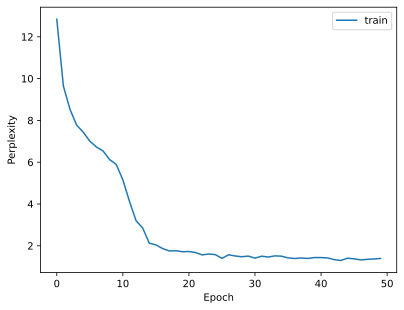

In [188]:
num_epochs, lr = 500, 0.1
device = "cuda:1"
loss = nn.CrossEntropyLoss()

# 初始化网络
rnn_layer = nn.RNN(num_embedding, num_hiddens, batch_first=True).to(device)
net = RNN(rnn_layer, device)
# 定义优化器
# opt = torch.optim.Adam(net.parameters(), lr=lr)
opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.8)
# 文本生成函数
pred_fn = lambda prefix: funcs.rnn_predict(prefix, 50, net, vocab, device)

net.train()
ppl_ = []

for epo in tqdm(range(num_epochs)):
    ppl, speed = train_rnn_one_epoch(
        net, train_iter, loss, opt, device, True)
    if (epo + 1) % 10 == 0:
        # print(f"epo:{epo+1}\t ppl:{ppl:.1f}\t")
        # print(pred_fn("time traveller"))
        ppl_.append(float(ppl))
    # scheduler.step()

print(f'困惑度[{ppl:.1f}], 速度[{speed:.1f} 词元/秒], 设备[{str(device)}]')
print(pred_fn('time traveller'))
print(pred_fn('traveller'))

plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.plot(ppl_)
plt.legend(["train"])

In [192]:
funcs.rnn_predict("smiled ", 500, net, vocab, device)

'smiled rouny at us then still smiling faintly andwith his hands deep in his trousers pockets he walked slowly out ofthe room and we heard his slippers shuffling down the long passage tohis laboratorythe psychologist looked at us i wonder what he s gotsome sleight of hand trick or other said the medical man and filbytried to tell us about a conjuror he had seen at burslem but before hehad finished his preface the time traveller come buck ar wurk buthet theer a fos of ermeneler twe sourou ane ploteatyof '